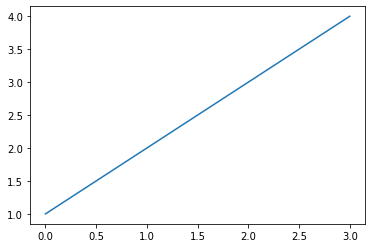

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])

In [2]:
import random
import gym
import sys
import numpy as np
from collections import deque,namedtuple
import os

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

In [3]:
env = gym.make('MountainCar-v0')

In [ ]:
s = env.reset()
for k in range(200):
    a = random.sample([0,1,2],1)[0]
    s_prime,r,_,_ = env.step(a)
    env.render()


    

In [4]:
state_sz = env.observation_space.shape[0]
action_sz = env.action_space.n
print('State space: ',state_sz)
print('Action space: ',action_sz)

State space:  2
Action space:  3


In [5]:
s = env.reset()
print(s)
s_prime,r,done,_ = env.step(0)
print(s_prime,r,done)

[-0.45410398  0.        ]
[-0.45562142 -0.00151744] -1.0 False


In [6]:
n_episodes=500
batch_size=128
gamma = 0.995
lr = 0.001
eps = 1.0
decay = 0.99

In [7]:
class DQN(nn.Module):
    def __init__(self,hidden_sz):
        super().__init__()
        self.hidden_sz = hidden_sz
        
        self.fc1 = nn.Linear(state_sz,self.hidden_sz)
        self.fc2 = nn.Linear(self.hidden_sz,self.hidden_sz)
        self.fc3 = nn.Linear(self.hidden_sz,action_sz)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [8]:
class NN(nn.Module):
    def __init__(self,in_dim,n_hid):
        super().__init__()
        self.in_dim = in_dim
        self.n_hid = n_hid
        
        self.fc1 = torch.nn.Linear(in_dim,n_hid,'linear')
        self.fc2 = torch.nn.Linear(n_hid,n_hid,'linear')
        self.fc3 = torch.nn.Linear(n_hid,1,'linear')
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        
        return y

In [9]:
class RND():
    def __init__(self,in_dim,n_hid):
        self.target = NN(in_dim,n_hid).cuda().eval()
        self.model = NN(in_dim,n_hid).cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.0001)
        
    def get_reward(self,x):
        y_true = self.target(x)
        y_pred = self.model(x)
        reward = torch.pow(y_pred - y_true,2).sum()

        return reward
    
    def update(self,Ri):
        Ri.sum().backward()
        self.optimizer.step()

In [10]:
rnd = RND(state_sz,128)

In [11]:
replay_buffer = deque(maxlen=10000)

In [12]:
transition = namedtuple('transition',['s_prime','reward','s','action','done'])

In [13]:
def store(transition):
    replay_buffer.append(transition)

In [14]:
dq_network = DQN(256).cuda()
target_network = DQN(256).cuda()

In [15]:
optimizer = Adam(dq_network.parameters(),lr=lr)
loss_fn = nn.MSELoss()

In [23]:
def update():
    
    if len(replay_buffer)<batch_size:
        return
    
    batch = random.sample(replay_buffer,batch_size)
    
    s = torch.FloatTensor(np.array([t.s for t in batch])).cuda()
    r = torch.FloatTensor(np.array([t.reward for t in batch])).cuda()
    s_prime = torch.FloatTensor(np.array([t.s_prime for t in batch])).cuda()
    a = torch.LongTensor(np.array([t.action for t in batch])).unsqueeze(1).cuda()
    done = torch.FloatTensor(np.array([t.done for t in batch])).cuda()
    
#     r_i = rnd.get_reward(s)
#     rnd.update(r_i)
    
    target = (r + gamma*target_network(s_prime).max(dim=1)[0]*(1-done))
    
    prediction = dq_network(s).gather(1,a)
    
    
    optimizer.zero_grad()
    
    loss = loss_fn(target.unsqueeze(1),prediction)
    
    loss.backward()
    
    optimizer.step() 
    
    

In [24]:
class Agent():
    def __init__(self,target_update_frequency=100,eps=1):
        
        self.eps = eps
        self.target_update_frequency = target_update_frequency
        self.target_update_counter = 0
        self.rewards = []
        
    def select_action(self,state,eps):
        
        t = np.random.random()
        if t < eps:
            a = np.random.choice(range(action_sz))
        else:
            q = dq_network(torch.FloatTensor(state).cuda())
            a = q.argmax().item()   
        return a
            
        
        
    def run_episode(self,render):

        s = env.reset()
        done = False
        total_reward = 0.0
        self.eps = self.eps * decay
        transition_count = 0
        
        while not done and transition_count<200:
            if render:
                env.render()
                
            eps = 0.0
            
            self.target_update_counter += 1
            
            if self.eps > 0.01:
                eps = self.eps
            else:
                eps = 0.01
            
            action = self.select_action(s,eps)
            
            s_prime,reward,done,_ = env.step(action)
            
            reward_i = torch.clamp(rnd.get_reward(torch.tensor(s).cuda()),-1.,1.).detach().item()
            
            combined_reward = reward + reward_i
            
            store(transition(s_prime,reward,s,action,done))
            
            total_reward += reward
            
#             if transition_count % 25 == 0:
#                 print (s_prime,reward_i)
                
            s = s_prime
            
            done = done
            
            update()
            
            transition_count+=1
            
        print('Transition Count: ',transition_count)    
        print('Episode Reward: ',total_reward)    
        self.rewards.append(total_reward)
            
    def train(self):
        
        for k in range(n_episodes):
            
            render = False
            
            if k % 100 <= 10:
                render = True
            
            print('Episode: ',k)
            self.run_episode(render)
            
           

            
            if self.target_update_counter >= self.target_update_frequency:

                self.target_update_counter = 0
                target_network.load_state_dict(dq_network.state_dict())
            
            
        
            
            
            

        
                
    

In [25]:
agent = Agent()

In [26]:
agent.train()

Episode:  0
Transition Count:  200
Episode Reward:  -200.0
Episode:  1
Transition Count:  200
Episode Reward:  -200.0
Episode:  2
Transition Count:  200
Episode Reward:  -200.0
Episode:  3
Transition Count:  200
Episode Reward:  -200.0
Episode:  4
Transition Count:  200
Episode Reward:  -200.0
Episode:  5
Transition Count:  200
Episode Reward:  -200.0
Episode:  6
Transition Count:  200
Episode Reward:  -200.0
Episode:  7
Transition Count:  200
Episode Reward:  -200.0
Episode:  8
Transition Count:  200
Episode Reward:  -200.0
Episode:  9
Transition Count:  200
Episode Reward:  -200.0
Episode:  10
Transition Count:  200
Episode Reward:  -200.0
Episode:  11
Transition Count:  200
Episode Reward:  -200.0
Episode:  12
Transition Count:  200
Episode Reward:  -200.0
Episode:  13
Transition Count:  200
Episode Reward:  -200.0
Episode:  14
Transition Count:  200
Episode Reward:  -200.0
Episode:  15
Transition Count:  200
Episode Reward:  -200.0
Episode:  16
Transition Count:  200
Episode Reward

Transition Count:  200
Episode Reward:  -200.0
Episode:  137
Transition Count:  200
Episode Reward:  -200.0
Episode:  138
Transition Count:  185
Episode Reward:  -185.0
Episode:  139
Transition Count:  155
Episode Reward:  -155.0
Episode:  140
Transition Count:  200
Episode Reward:  -200.0
Episode:  141
Transition Count:  154
Episode Reward:  -154.0
Episode:  142
Transition Count:  200
Episode Reward:  -200.0
Episode:  143
Transition Count:  180
Episode Reward:  -180.0
Episode:  144
Transition Count:  200
Episode Reward:  -200.0
Episode:  145
Transition Count:  180
Episode Reward:  -180.0
Episode:  146
Transition Count:  195
Episode Reward:  -195.0
Episode:  147
Transition Count:  161
Episode Reward:  -161.0
Episode:  148
Transition Count:  186
Episode Reward:  -186.0
Episode:  149
Transition Count:  200
Episode Reward:  -200.0
Episode:  150
Transition Count:  200
Episode Reward:  -200.0
Episode:  151
Transition Count:  200
Episode Reward:  -200.0
Episode:  152
Transition Count:  144
E

Transition Count:  162
Episode Reward:  -162.0
Episode:  272
Transition Count:  147
Episode Reward:  -147.0
Episode:  273
Transition Count:  157
Episode Reward:  -157.0
Episode:  274
Transition Count:  200
Episode Reward:  -200.0
Episode:  275
Transition Count:  159
Episode Reward:  -159.0
Episode:  276
Transition Count:  175
Episode Reward:  -175.0
Episode:  277
Transition Count:  154
Episode Reward:  -154.0
Episode:  278
Transition Count:  164
Episode Reward:  -164.0
Episode:  279
Transition Count:  200
Episode Reward:  -200.0
Episode:  280
Transition Count:  159
Episode Reward:  -159.0
Episode:  281
Transition Count:  186
Episode Reward:  -186.0
Episode:  282
Transition Count:  166
Episode Reward:  -166.0
Episode:  283
Transition Count:  159
Episode Reward:  -159.0
Episode:  284
Transition Count:  182
Episode Reward:  -182.0
Episode:  285
Transition Count:  194
Episode Reward:  -194.0
Episode:  286
Transition Count:  182
Episode Reward:  -182.0
Episode:  287
Transition Count:  166
E

Transition Count:  110
Episode Reward:  -110.0
Episode:  408
Transition Count:  105
Episode Reward:  -105.0
Episode:  409
Transition Count:  96
Episode Reward:  -96.0
Episode:  410
Transition Count:  108
Episode Reward:  -108.0
Episode:  411
Transition Count:  108
Episode Reward:  -108.0
Episode:  412
Transition Count:  109
Episode Reward:  -109.0
Episode:  413
Transition Count:  91
Episode Reward:  -91.0
Episode:  414
Transition Count:  101
Episode Reward:  -101.0
Episode:  415
Transition Count:  107
Episode Reward:  -107.0
Episode:  416
Transition Count:  108
Episode Reward:  -108.0
Episode:  417
Transition Count:  89
Episode Reward:  -89.0
Episode:  418
Transition Count:  107
Episode Reward:  -107.0
Episode:  419
Transition Count:  108
Episode Reward:  -108.0
Episode:  420
Transition Count:  109
Episode Reward:  -109.0
Episode:  421
Transition Count:  104
Episode Reward:  -104.0
Episode:  422
Transition Count:  106
Episode Reward:  -106.0
Episode:  423
Transition Count:  107
Episode

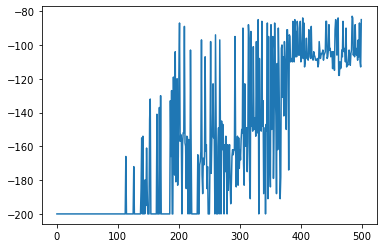

In [27]:
plt.plot(agent.rewards);

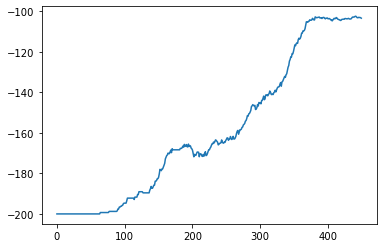

In [28]:
plt.plot([np.mean(agent.rewards[i-50:i]) for i in range(50,500)]);

In [29]:
print(max(agent.rewards))
print(np.mean(agent.rewards))
print(np.std(agent.rewards))

-83.0
-157.808
42.544742753952576
